In [21]:
#FOR 5km Bufer
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio import features
import matplotlib.pyplot as plt
from rasterio.plot import show

# Create DataFrame
df = pd.read_csv('filtered_fire stations.csv')

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON, df.LAT), crs="EPSG:4269")

# Buffer zones of 5km
buffered_geometries = gdf['geometry'].buffer(0.05)  # 0.05 degrees is approx 5km

# Set CRS for California shapefile
california_border = gpd.read_file('California.shp')
california_border.crs = 'EPSG:4269' 

# Determine raster extent and pixel size
xmin, ymin, xmax, ymax = california_border.total_bounds
pixel_size = 0.01  # Adjust as needed
width = int((xmax - xmin) / pixel_size)
height = int((ymax - ymin) / pixel_size)
transform = from_origin(xmin, ymax, pixel_size, pixel_size)

# Create raster for buffer zones
buffered_raster = np.zeros((height, width), dtype=np.uint8)
buffered_raster_mask = features.geometry_mask(buffered_geometries, transform=transform, invert=True, out_shape=(height, width))
buffered_raster[buffered_raster_mask] = 2  # Set pixels inside buffered geometries to 2

# Create raster for California border
california_raster = np.zeros((height, width), dtype=np.uint8)
california_raster_mask = features.geometry_mask(california_border['geometry'], transform=transform, invert=True, out_shape=(height, width))
california_raster[california_raster_mask] = 1  # Set pixels inside California border to 1

# Combine these two rasters
combined_raster = np.maximum(buffered_raster, california_raster)

# Save combined raster to file
combined_raster_path = 'combined_pfas_california_raster.tif'
with rasterio.open(
    combined_raster_path, 'w',
    driver='GTiff',
    height=combined_raster.shape[0],
    width=combined_raster.shape[1],
    count=1,
    dtype=rasterio.uint8,
    crs="EPSG:4269",
    transform=transform,
) as dst:
    dst.write(combined_raster, 1)

# Load combined raster from file
with rasterio.open(combined_raster_path) as src:
    combined_raster_data, combined_transform = rasterio.mask.mask(src, california_border.geometry, crop=True)
    # Update metadata
    out_meta = src.meta.copy()
    out_meta.update({
        "height": combined_raster_data.shape[1],
        "width": combined_raster_data.shape[2],
        "transform": combined_transform
    })

# Save clipped raster to file
clipped_raster_path = '5km_reprocessed_firestation2.tif'
with rasterio.open(clipped_raster_path, 'w', **out_meta) as dst:
    dst.write(combined_raster_data)


/tmp/ipykernel_11431/4156898058.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_geometries = gdf['geometry'].buffer(0.05)  # 0.05 degrees is approx 5km


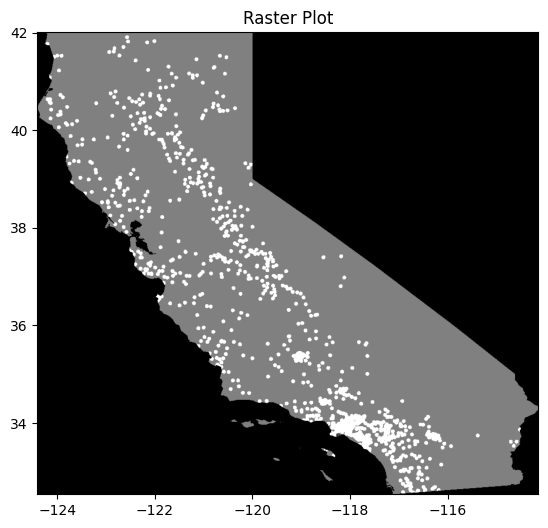

In [23]:
# Open the raster file
with rasterio.open('combined/4km_test.tif') as src:
    # Read the data
    raster_data = src.read(1)  # Read the first band, or use src.read() to get all bands

    # Plot using rasterio's built-in plotting function
    fig, ax = plt.subplots(figsize=(8, 6))
    show(raster_data, ax=ax, cmap='gray')  # Use a colormap like 'gray' or any other

    # Optionally, you can overlay the raster's bounds
    show(src, ax=ax, cmap='gray')

plt.title('Raster Plot')
plt.show()

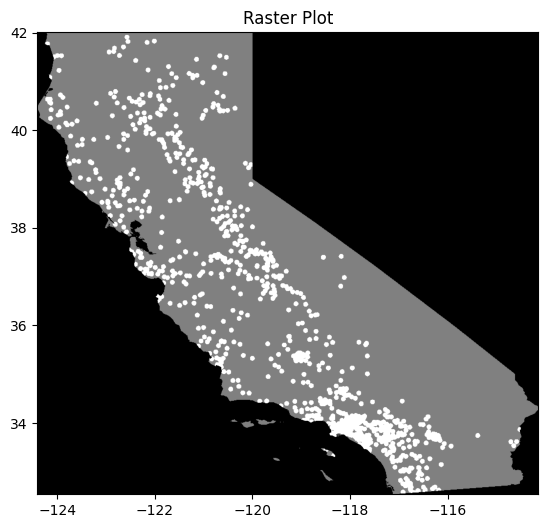

In [22]:
# Open the raster file
with rasterio.open('5km_reprocessed_firestation2.tif') as src:
    # Read the data
    raster_data = src.read(1)  # Read the first band, or use src.read() to get all bands

    # Plot using rasterio's built-in plotting function
    fig, ax = plt.subplots(figsize=(8, 6))
    show(raster_data, ax=ax, cmap='gray')  # Use a colormap like 'gray' or any other

    # Optionally, you can overlay the raster's bounds
    show(src, ax=ax, cmap='gray')

plt.title('Raster Plot')
plt.show()